# Follow these instructions:

Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

## Assignment 8: Text Mining using Dimensionality Reduction Methods [_/100 Marks]



This dataset comes from the Amazon website and represents 1,000 reviews which were labeled (by humans) as positive or negative. In this assignment, we will study apply dimensionality reduction methods to improve our understanding of text data and to predict the sentiment of a set of texts. 

In [1]:
!gdown https://drive.google.com/uc?id=1habwBbNCj6wFIDvxLa7hdP2xakA_tcDG

zsh:1: no matches found: https://drive.google.com/uc?id=1habwBbNCj6wFIDvxLa7hdP2xakA_tcDG


In [26]:
import numpy as np
import pandas as pd
# import umap
import umap.umap_ as umap
from sklearn.decomposition import PCA, TruncatedSVD
import sklearn.feature_extraction.text as sktext
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import product
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
seed = 0

## Task 1: Decomposition of the texts [ /66 marks]

### Question 1.1

The dataset comes with the text and a binary variable which represents the sentiment, either positive or negative. Import the data and use sklearn's `TfidfVectorizer` to eliminate accents, special characters, and stopwords. In addition, make sure to eliminate words that appear in less than 5% of documents and those that appear in over 95%. You can also set `sublinear_tf` to `True`. After that, split the data into train and test with `test_size = 0.2` and `seed = seed`. Calculate the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) for both train and test. Note that you need to fit and transform the inputs for the train set but you only need to transform the inputs for the test set. Don't forget to turn the sparse matrices to dense ones after you apply the `Tf-Idf` transform.  

In [3]:
# Load the data [ /1 marks]
df = pd.read_csv("Reviews_sample.csv")

# Display the first 5 rows [ /1 marks]
df.head(5)

,text,label
0,Stuning even for the non-gamer: This sound tr...,1
1,The best soundtrack ever to anything.: I'm re...,1
2,Amazing!: This soundtrack is my favorite musi...,1
3,Excellent Soundtrack: I truly like this sound...,1
4,"Remember, Pull Your Jaw Off The Floor After H...",1


In [4]:
# Defining the TfIDFTransformer [ /4 marks]
from sklearn.feature_extraction.text import TfidfVectorizer

transformer = TfidfVectorizer(sublinear_tf = True, min_df = 0.05, max_df = 0.90, strip_accents='unicode', stop_words='english')

# Train/test split [ /2 marks]

X = df['text']
y = df['label']

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.3, random_state = seed)

# Calculate the Tf-Idf transform on training and test [ /4 marks]
XtrainTransform = transformer.fit_transform(Xtrain).toarray()
XtestTransform = transformer.transform(Xtest).toarray()

From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required). Print the number of indices in the ouput using [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [5]:
# Print the number of indices [ /2 marks]
print("number of indices is %d " % len(transformer.get_feature_names()))

number of indices is 69 


/Users/dongpochen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Question 1.2
Now we have the TfIDF matrix so we can start working on the data. We hope to explore what some commonly occuring concepts are in the text reviews. We can do this using PCA. A PCA transform of the TF-IDF matrix will give us a basis of the text data, each component representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic. Calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts.



Text(0, 0.5, 'Explained variance %')

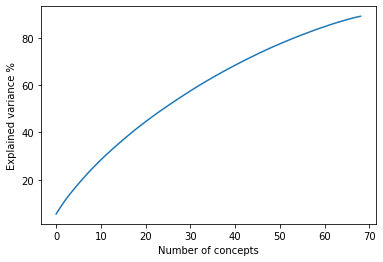

In [6]:
# Apply PCA on training data and get the explained variance [ / 4 marks]
pca = PCA(n_components=69)
pca.fit(XtrainTransform)

cev = np.zeros(69)
for i, var in enumerate(pca.explained_variance_):
    if (i != 0):
        cev[i] = cev[i - 1] + var * 100
    else:
        cev[i] = var * 100 

# Plotting explained variance with number of concepts [ / 4 marks]
plt.plot(range(0, 69), cev)
plt.xlabel('Number of concepts')
plt.ylabel('Explained variance %')

**Question:** Exactly how many concepts do we need to correctly explain at least 80% of the data?


In [7]:
# To get the exact index where the variance is above 80% [ / 4 marks]
for i, var in enumerate(cev):
    if (var >= 80):
        print (i)
        break

54


**Your Answer:** 

we need 54 concepts to correctly explain at least 80% of the data

### Question 1.3

Let's examine the first three concepts by looking how many variance they explained and showing the 10 words that are the most important in each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).


In [8]:
# Explained variance [ / 2 marks]
explained_variance = cev[2]
print('The first three components explain %.2f%% of the variance.' % (explained_variance))

The first three components explain 11.33% of the variance.


In [9]:
# Get 10 most important words for each component [ / 4 marks]
word_index = transformer.get_feature_names_out()

concept_1 = np.abs(pca.components_[0,:])
concept_2 = np.abs(pca.components_[1,:])
concept_3 = np.abs(pca.components_[2,:])

In [10]:
# Words for concept 1 [ / 2 marks]
concept_1_10th = sorted(concept_1)[-10]
word_index[concept_1 >= concept_1_10th]

array(['book', 'buy', 'great', 'just', 'love', 'movie', 'product', 'read',
       'reading', 'written'], dtype=object)

In [11]:
# Words for concept 2 [ / 2 marks]
concept_2_10th = sorted(concept_2)[-10]
word_index[concept_2 >= concept_2_10th]

array(['bad', 'best', 'book', 'don', 'great', 'like', 'little', 'love',
       'movie', 'worst'], dtype=object)

In [12]:
# Words for concept 3 [ / 2 marks]
concept_3_10th = sorted(concept_3)[-10]
word_index[concept_3 >= concept_3_10th]

array(['better', 'bought', 'buy', 'good', 'great', 'love', 'movie',
       'product', 'time', 'wear'], dtype=object)


**Question:** What is the cumulative variance explained by these three concepts? What would you name each of these concepts? [ / 2 marks]

*Hint: If in a concept you would get the words 'dog', 'cat', 'fish' as the most important ones, you could name the concept 'animals' or 'pets'.*

**Your answer:** 

I will name concept 1 as book product, concept 2 as describle , concept 3 as describle

### Question 1.4

 Apply the PCA transformation to the test dataset. Use only the first two components and make a scatter plot of the cases. Identify positive and negative cases by colouring points with different sentiments with different colours.


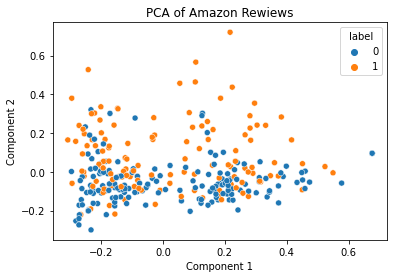

In [13]:
# Apply PCA to the test dataset [ / 2 marks]
pca_2 = PCA(n_components=2)
pca.fit(XtrainTransform)
Z1 = pca.transform(XtestTransform)


# Plot the two different set of points with different markers and labels [ /4 marks]
sns.scatterplot(x=Z1[:, 0], y=Z1[:, 1], hue=ytest)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA of Amazon Rewiews")
plt.show()


**Question:** What can we say about where the positive and negative cases lie in our plot? Could we use these concepts to discriminate positive and negative cases? If yes, why? If no, why not? Discuss your findings. [ /2 marks]
 
**Your answer:** 
The positive and negative cases, the distribution is relatively uneven, and we can't distinguish it because they are not distributed according to clusters

### Question  1.5

Repeat the process above, only now using a UMAP projection with two components. Test all combinations of ```n_neighbors=[2, 10, 25]``` and ```min_dist=[0.1, 0.25, 0.5]``` over the train data and choose the projection that you think is best, and apply it over the test data. Use 1000 epochs, a cosine metric and random initialization. If you have more than 8GB of RAM (as in Colab), you may want to set ```low_memory=False``` to speed up computations.

*Hint: [This link](https://stackoverflow.com/questions/16384109/iterate-over-all-combinations-of-values-in-multiple-lists-in-python) may be helpful.*



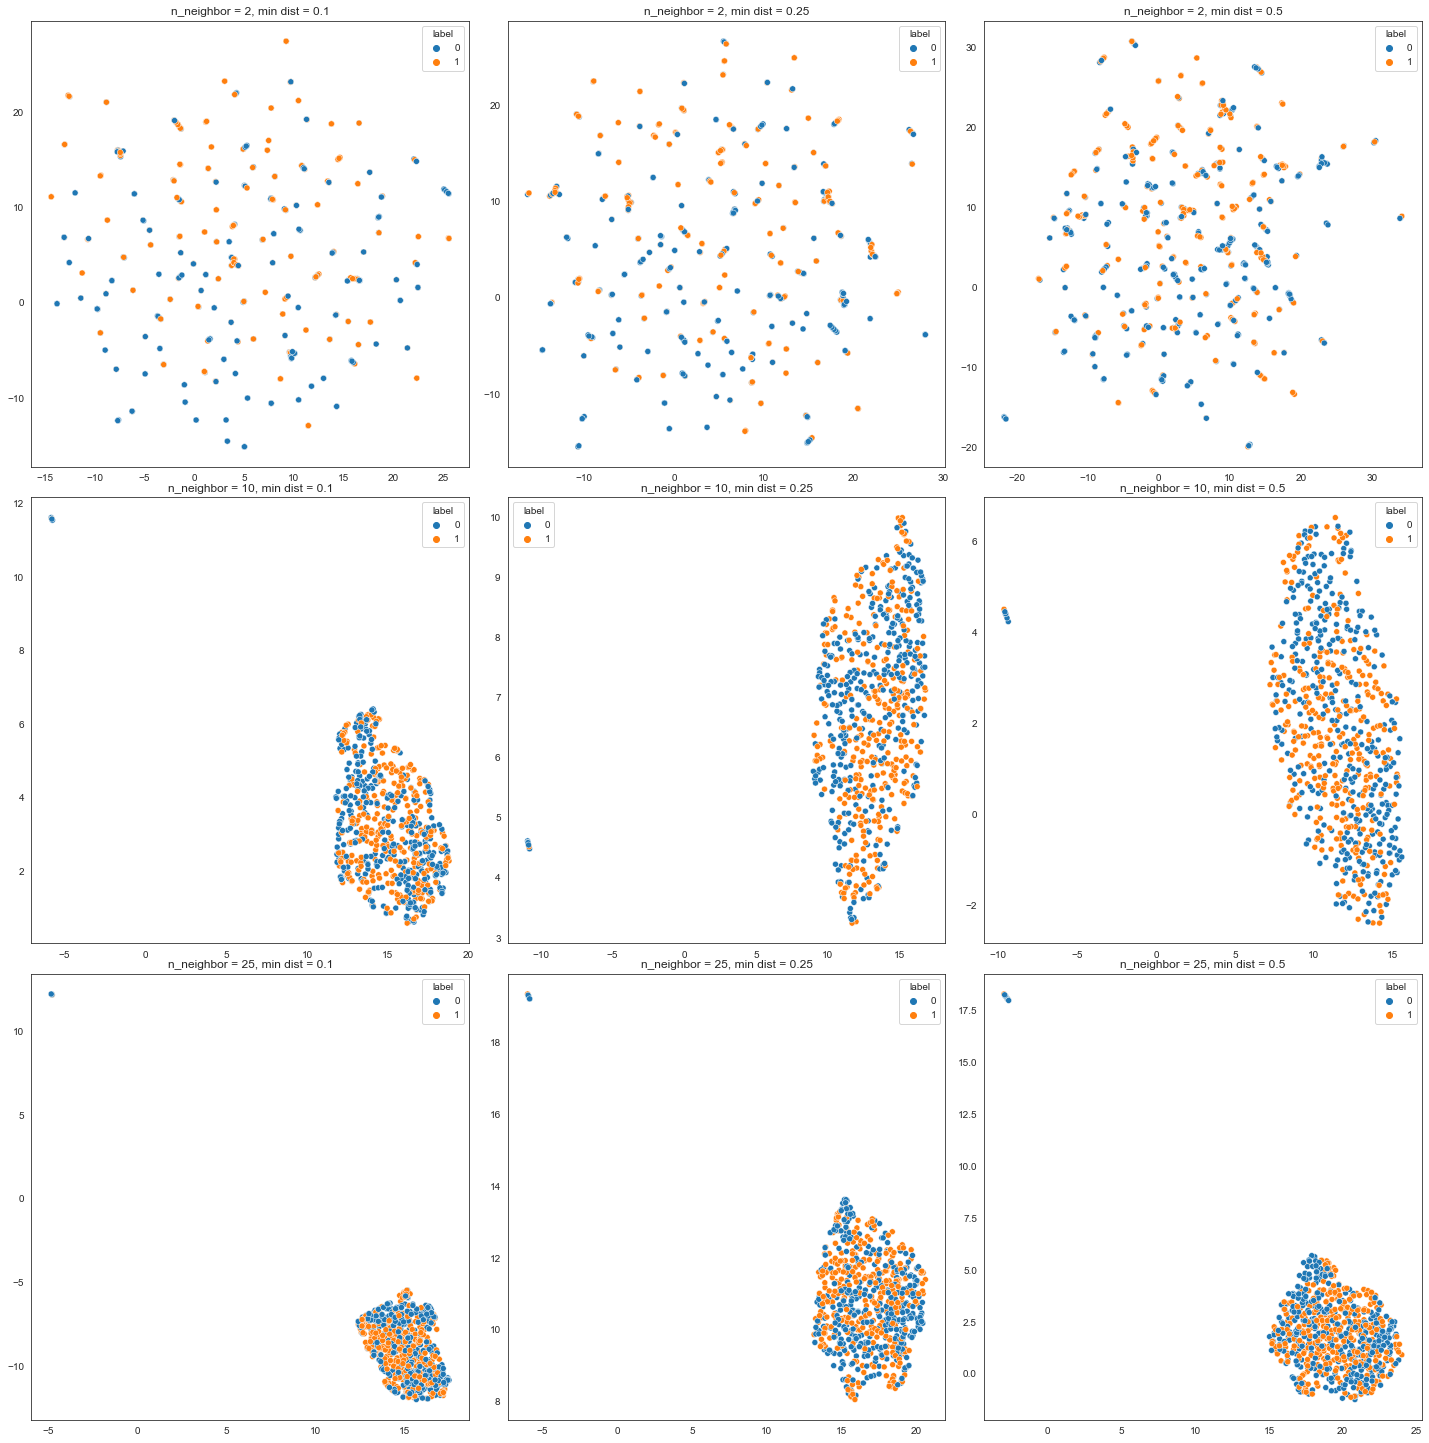

In [18]:
# Set parameters
fig, axs = plt.subplots(3, 3, figsize=(20,20))
n_neighbors=[2, 10, 25]
min_dist=[0.1, 0.25, 0.5]
fig.tight_layout()
sns.set_style('white')

# Create UMAP and plots [ / 8 marks]
for i, n_neighbor in enumerate(n_neighbors):
    for j, min_dis in enumerate(min_dist):
        reducer = umap.UMAP(n_components=2,              # Number of components. UMAP is robust to larger values
                    n_neighbors = n_neighbor,
                    min_dist = min_dis,
                    metric='hellinger',          # Metric to use.
                    n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                    low_memory=True,             # Run slower, but with less memory.
                    random_state=seed,             # Random seed
                    verbose=False                 # Verbosity
                   )

        UMAP_embedding = reducer.fit_transform(XtrainTransform)
        sns.scatterplot(ax = axs[i][j], x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=ytrain)
        axs[i][j].set_title("n_neighbor = " + str(n_neighbor) + ", min dist = " + str(min_dis))

plt.show()

**Question:** Which paramter would you choose? [ / 2 makrs]

**Your Answer:** I would choose n_components = 2 and min_dist = 0.1. The better PCA graph will increase the separability of data.

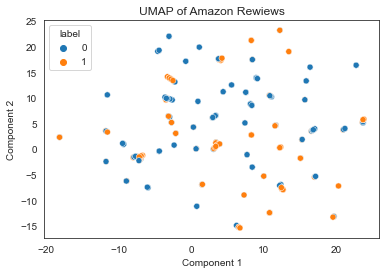

In [21]:
# Choose the paramters that you think are best and apply to test set [ / 4 marks]
reducer = umap.UMAP(n_neighbors=2,              # Number of neareast neighbours to use. 
                    n_components=2,              # Number of components. UMAP is robust to larger values
                    min_dist = 0.1,
                    metric='hellinger',          # Metric to use.
                    n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                    low_memory=True,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    random_state=seed,             # Random seed
                    verbose=False                 # Verbosity
                   )

# Now we train and calculate the embedding!
UMAP_embedding = reducer.fit_transform(XtestTransform)

# Create plot [ /2 marks]
sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=ytest)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP of Amazon Rewiews")
plt.show()


**Question:** How does the plot compare to the PCA one? [ /2 marks]

**Your answer:** It is much better than the PCA one, the positive class and negative class are distributed more separately. And there are a lot pounts with same class is overlapping.

## Task 2: Benchmarking predictive capabilities of the compressed data [ / 34 marks]

For this task, we will benchmark the predictive capabilities of the compressed data against the original one. 



### Question 2.1 
Train a regularized logistic regression over the original TfIDF train set (with no compression) using l2 regularization. Calculate the AUC score and plot the ROC curve for the original test set.

0.815950226244344


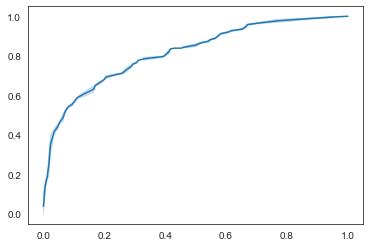

In [24]:
# Train and test using model LogisticRegressionCV [ /4 marks]

# Define the model
logReg = LogisticRegressionCV(cv=5)

# Fit on the training dataset
logReg.fit(XtrainTransform, ytrain)

# Apply to the test dataset
ypred = logReg.predict(XtestTransform)
ytest_prob1 = logReg.predict_proba(XtestTransform)

# Plot ROC curve and compute AUC score [ /4 marks]
# Calculate the ROC curve points and plot
fpr1, tpr1, _ = roc_curve(ytest, ytest_prob1[:,1])
sns.lineplot(x = fpr1,y = tpr1)

# Calculate the AUC and print it
AUC1 = roc_auc_score(ytest, ytest_prob1[:,1])
print(AUC1)

### Question 2.2 
Train a regularized logistic regression over an SVD-reduced dataset (with 10 components) using l2 regularization. Calculate the AUC score and plot the ROC curve for the SVD-transformed test set.

0.7783031674208145


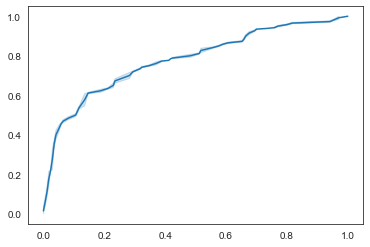

In [29]:
# Apply SVD first [ / 4 marks]
svd = TruncatedSVD(n_components=10, # How many concepts to extract
                   n_iter=10, # How many iterations to run
                   random_state=seed # Random state. As SVD is rotation-invariant, we need to set this
                  )

# Train and test using model LogisticRegressionCV [ /4 marks]
logReg = LogisticRegressionCV(cv=5)

# Define the model
model = Pipeline([
    ('svd', svd), 
    ('log', logReg)])

# Fit on the training dataset
model.fit(XtrainTransform, ytrain)

# Apply to the test dataset
ypred = model.predict(XtestTransform)
ytest_prob2 = model.predict_proba(XtestTransform)

# Plot ROC curve and compute AUC score [ /4 marks]
# Calculate the ROC curve points and plot
fpr2, tpr2, _ = roc_curve(ytest, ytest_prob2[:,1])
sns.lineplot(x = fpr2,y = tpr2)

# Calculate the AUC and print it
AUC2 = roc_auc_score(ytest, ytest_prob2[:,1])
print(AUC2)

### Question 2.3 
Train a regularized logistic regression over the UMAP-reduced dataset (with 10 components using the same parameters as Task 1.5) using l2 regularization. Calculate the AUC score and plot the ROC curve for the UMAP-transformed test set.

0.6895475113122173


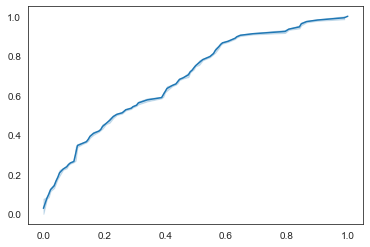

In [30]:
# Apply UMAP first [ / 4 marks]
reducer = umap.UMAP(n_neighbors=2,              # Number of neareast neighbours to use. 
                    n_components=10,              # Number of components. UMAP is robust to larger values
                    min_dist = 0.1,
                    metric='hellinger',          # Metric to use.
                    n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                    low_memory=True,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    random_state=seed,             # Random seed
                    verbose=False                 # Verbosity
                   )

# Train and test using model LogisticRegressionCV [ /4 marks]
logReg = LogisticRegressionCV(cv=5)

# Define the model
model = Pipeline([
    ('umap', reducer), 
    ('log', logReg)])

# Fit on the training dataset
model.fit(XtrainTransform, ytrain)

# Apply to the test dataset
ypred = model.predict(XtestTransform)
ytest_prob3 = model.predict_proba(XtestTransform)

# Plot ROC curve and compute AUC score [ /4 marks]
# Calculate the ROC curve points and plot
fpr3, tpr3, _ = roc_curve(ytest, ytest_prob3[:,1])
sns.lineplot(x = fpr3, y = tpr3)

# Calculate the AUC and print it
AUC3 = roc_auc_score(ytest, ytest_prob3[:,1])
print(AUC3)

### Question 2.4 
Compare the performance of the three models. Which one is the best. [ / 2 marks] 

**Your Answer:** 

The first one is best, It has the maximum auc value and largest area below roc curve.